#Setup

In [1]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
print("\nWelcome to advanced top sites")
!ls
!rm -f spark-3.3.[01]-bin-hadoop3.tgz* 
!rm -rf spark-3.3.[01]-bin-hadoop3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz
!ls -alt


Welcome to advanced top sites
sample_data
--2023-05-11 00:03:35--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  89.0MB/s    in 3.4s    

2023-05-11 00:03:39 (84.0 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

total 292368
drwxr-xr-x  1 root root      4096 May 11 00:03 .
drwxr-xr-x  1 root root      4096 May 10 20:43 ..
drwxr-xr-x  1 root root      4096 May  9 13:35 sample_data
drwxr-xr-x  4 root root      4096 May  9 13:34 .config
-rw-r--r--  1 root root 299360284 Feb 10 21:28 spark-3.3.2-bin-hadoop3.tgz
drwxr-xr-x 13  501 1000      4096 Feb 10 

In [2]:
# install findspark if not already installed
!pip3 install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *

In [4]:
# "SparkSession" and "sc" are are key handles in to Spark API
##SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("bikes").getOrCreate()

#Downloading the Dataset

In [5]:
# get file for given year from TfL open data
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip


--2023-05-11 00:04:04--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.100.13, 104.16.101.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.100.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M  73.0MB/s    in 2.9s    

2023-05-11 00:04:07 (73.0 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  

#Reading files into a Dataframe

In [6]:
#read all the files into one dataframe

# MULTIPLE FILES INPUT AND ANALYSED (presuming identical schema - should test first!)
file="./*Journey*csv"
journey_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(file)) # i.e pass a Python list of files to load (into a single DF)

#Analyzing the Journey Dataframe

In [7]:
# show top 10 rows of the dataframe
journey_df.show(10)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [8]:
# Print the schema of the DataFrame
journey_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [9]:
# Convert the date columns to the appropriate format
journey_df = journey_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm")) \
                       .withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))

# Print the updated schema
journey_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [10]:
# Get the total number of rows in the DataFrame
total_rows = journey_df.count()
print("Total number of rows in the DataFrame:", total_rows)

Total number of rows in the DataFrame: 11481596


In [11]:
from pyspark.sql.functions import col, sum, when, isnull

# Check for null values in each column
journey_null_count_df = journey_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in journey_df.columns])
# Show the resulting DataFrame
journey_null_count_df.show()

+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+
|Rental Id_null_count|Duration_null_count|Bike Id_null_count|End Date_null_count|EndStation Id_null_count|EndStation Name_null_count|Start Date_null_count|StartStation Id_null_count|StartStation Name_null_count|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+
|             1239113|            1239113|           1239113|            1239113|                 1239245|                   1239245|              1239113|                   1239113|                     1239113|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+-------------------

#Filtering Dataset for Spring and Autumn months

In [12]:
from pyspark.sql.functions import month, col, to_date, year

#First Extract Autumn and spring and then will see how many null values it has.

# Define the date format
date_format = "dd/MM/yyyy HH:mm"

# Convert the "Start Date" column to the correct date format, extract the month and year
df = journey_df.withColumn("month", month(to_date(col("Start Date"), date_format)))\
               .withColumn("year", year(to_date(col("Start Date"), date_format)))

# Filter the data for Spring and Autumn months and include only records from 2014
spring_months = [3, 4, 5, 6]
autumn_months = [9, 10, 11, 12]

spring_df = df.filter(df["month"].isin(spring_months))
autumn_df = df.filter((df["month"].isin(autumn_months)) & (df["year"] == 2014))

In [13]:
#The month and year column were added to easily fillter the spring and autumn months
df.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
| 34263367|    1080|   9076|2014-06-24 00:57:00|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|    6|2014|
| 34603487|     660|   6328|2014-07-03 11:51:00|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|    7|2014|
| 34689078|     120|   2006|2014-07-05 15:09:00|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|    7|2014|
| 34724273|    1260|   7904|2014-07-06 16:35:00|          695|Islington Green, ...|2014-

#Analyzing the Spring and Autumn Data

In [14]:
# Prints the count of rows for spring_df and autumn_df dataframes.
print(spring_df.count())
print(autumn_df.count())

3466010
3221750


###Sorting the Spring and Autumn Data by Starting Date

In [15]:
# Sort the DataFrame by 'Start Date' column
spring_df = spring_df.orderBy("Start Date")
autumn_df = autumn_df.orderBy("Start Date")

# Show the top 10 rows of the sorted DataFrame
spring_df.show(10)
autumn_df.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
| 30793610|     540|  11306|2014-03-01 00:09:00|          534|Goldsmiths Row, H...|2014-03-01 00:00:00|            236|Fashion Street, W...|    3|2014|
| 30793609|    1800|   6124|2014-03-01 00:30:00|          243|Gloucester Street...|2014-03-01 00:00:00|            122|Norton Folgate, L...|    3|2014|
| 30793606|    1560|  10203|2014-03-01 00:26:00|          524|Lancaster Gate , ...|2014-03-01 00:00:00|            524|Lancaster Gate , ...|    3|2014|
| 30793608|     180|  11730|2014-03-01 00:03:00|          581|New Cavendish Str...|2014-

In [16]:
from pyspark.sql.functions import desc

# Sort the DataFrame in descending order by 'start_date'
sorted_spring_df_desc = spring_df.orderBy(desc("Start Date"))
sorted_autumn_df_desc = autumn_df.orderBy(desc("Start Date"))

# Show the last 10 rows of the sorted DataFrame
sorted_spring_df_desc.show(10)
sorted_autumn_df_desc.show(10)

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
| 34503859|     360|   2665|2014-07-01 00:05:00|           80|Webber Street , S...|2014-06-30 23:59:00|            154|Waterloo Station ...|    6|2014|
| 34503856|    1080|  11255|2014-07-01 00:17:00|          694|Putney Rail Stati...|2014-06-30 23:59:00|            171|Collingham Garden...|    6|2014|
| 34503857|     780|   1217|2014-07-01 00:12:00|          660|West Kensington S...|2014-06-30 23:59:00|            727|Chesilton Road, F...|    6|2014|
| 34503855|     540|   5433|2014-07-01 00:08:00|          501|Cephas Street, Be...|2014-

###Cleaning the Data

####Checking for Null Values

In [17]:
#Counting the null values in spring dataset
spring_null_count_df = spring_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in spring_df.columns])
spring_null_count_df.show()

#Counting the null values in autumn dataset
autumn_null_count_df = autumn_df.agg(*[count(when(col(c).isNull(), c)).alias(c + '_null_count') for c in autumn_df.columns])
autumn_null_count_df.show()

+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+----------------+---------------+
|Rental Id_null_count|Duration_null_count|Bike Id_null_count|End Date_null_count|EndStation Id_null_count|EndStation Name_null_count|Start Date_null_count|StartStation Id_null_count|StartStation Name_null_count|month_null_count|year_null_count|
+--------------------+-------------------+------------------+-------------------+------------------------+--------------------------+---------------------+--------------------------+----------------------------+----------------+---------------+
|                   0|                  0|                 0|                  0|                      32|                        32|                    0|                         0|                           0|               0|              0|
+-------------------

In [18]:
#------------------------------Spring---------------------------------------------
#Getting the rows where there were null values in the sring dataset
spring_null_rows_df = spring_df.filter(spring_df["EndStation Id"].isNull() | spring_df["EndStation Name"].isNull())

#Showing the rows with null values in the spring dataset
spring_null_rows_df.show(spring_null_rows_df.count())

#------------------------------Autumn---------------------------------------------

#Getting the rows where there were null values in the autumn dataset
autumn_null_rows_df = autumn_df.filter(autumn_df["EndStation Id"].isNull() | autumn_df["EndStation Name"].isNull())

#Showing the rows with null values in the autumn dataset
autumn_null_rows_df.show(autumn_null_rows_df.count())

+---------+--------+-------+-------------------+-------------+---------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+---------------+-------------------+---------------+--------------------+-----+----+
| 31152127|  492300|   9676|2014-03-20 18:11:00|         null|           null|2014-03-15 01:26:00|            217|Wormwood Street, ...|    3|2014|
| 31199183|    1320|   7778|2014-03-16 14:16:00|         null|           null|2014-03-16 13:54:00|            100|Albert Embankment...|    3|2014|
| 31572507|     240|   2531|2014-03-31 07:33:00|         null|           null|2014-03-31 07:29:00|             71|Newgate Street , ...|    3|2014|
| 31795486|     300|   8208|2014-04-08 13:33:00|         null|           null|2014-04-08 13:28:00|            663|Clar

####Dealing with Null Values

In the Spring dataset, the total number of rows in the spring dataset is 3,466,010, the 32 rows with null values are a very small fraction of the dataset (less than 0.001%). In this case, it seems reasonable to simply remove the rows with null values, as they are unlikely to have a significant impact on the results. Similarly in the autumn dataset the fraction of null values is very small so we weill drop the null values.

In [19]:
#Remove rows with missing values in 'EndStation Id' and 'EndStation Name' columns from spring_df
spring_clean = spring_df.dropna(subset=["EndStation Id", "EndStation Name"])

#Remove rows with missing values in 'EndStation Id' and 'EndStation Name' columns from autumn_df
autumn_clean = autumn_df.dropna(subset=["EndStation Id", "EndStation Name"])

In [20]:
spring_clean.show(5)

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
| 30793609|    1800|   6124|2014-03-01 00:30:00|          243|Gloucester Street...|2014-03-01 00:00:00|            122|Norton Folgate, L...|    3|2014|
| 30793608|     180|  11730|2014-03-01 00:03:00|          581|New Cavendish Str...|2014-03-01 00:00:00|            301|Marylebone Lane, ...|    3|2014|
| 30793606|    1560|  10203|2014-03-01 00:26:00|          524|Lancaster Gate , ...|2014-03-01 00:00:00|            524|Lancaster Gate , ...|    3|2014|
| 30793607|     180|   9890|2014-03-01 00:03:00|          558|John Islip Street...|2014-

###Converting Duration Units to Minutes

In [21]:
#Create a new column 'Duration_minutes' by dividing the 'Duration' column by 60
spring_clean = spring_clean.withColumn("Duration_minutes", col("Duration") / 60)
autumn_clean = autumn_clean.withColumn("Duration_minutes", col("Duration") / 60)

###Calculating the Average Ride Duration for Both Spring and Autumn

In [22]:
#avg_ride_duration_spring = spring_clean.agg({"Duration_minutes": "mean"}).show()
#avg_ride_duration_autumn = autumn_clean.agg({"Duration_minutes": "mean"}).show()

spring_avg_duration = spring_clean.agg(avg("Duration_minutes")).collect()[0][0]
autumn_avg_duration = autumn_clean.agg(avg("Duration_minutes")).collect()[0][0]

print("Average ride duration in spring:", spring_avg_duration)
print("Average ride duration in autumn:", autumn_avg_duration)

Average ride duration in spring: 25.49551324330391
Average ride duration in autumn: 22.69824235542872


###Comparing the Average Ride Durations in Spring and Autumn

In [23]:
if spring_avg_duration > autumn_avg_duration:
    print("Ride durations are longer in spring.")
elif autumn_avg_duration > spring_avg_duration:
    print("Ride durations are longer in autumn.")
else:
    print("Ride durations are equal in spring and autumn.")

Ride durations are longer in spring.


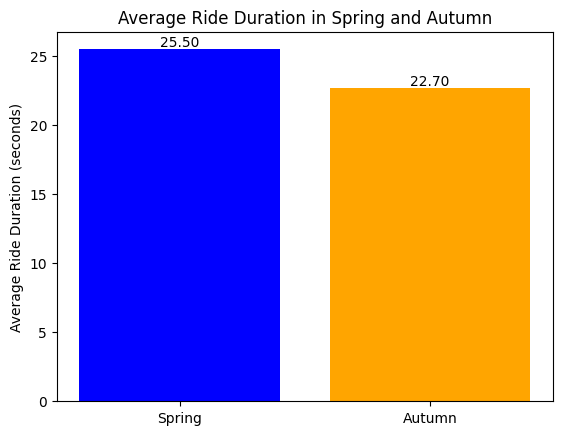

In [24]:
import matplotlib.pyplot as plt

#Create the bar plot
bars = plt.bar(['Spring', 'Autumn'], [spring_avg_duration, autumn_avg_duration], color=['skyblue', 'orange'])

#Add the average values as text above the bars
for bar, value in zip(bars, [spring_avg_duration, autumn_avg_duration]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            '{:.2f}'.format(value), 
             ha='center',
             va='bottom',
             fontsize=10)

#Set the y-axis label and the plot title
plt.ylabel('Average Ride Duration (seconds)')
plt.title('Average Ride Duration in Spring and Autumn')

#Display the plot
plt.show()

But we can not conclude it based on the avg durations

###Performing a statistical test

Performing a statistical test to determine if there is a significant difference in ride durations between spring and autumn.

The t-statistic measures the difference between the means of the two groups relative to the variability of the data. 
The p-value is a measure of the probability that the observed difference occurred by chance alone.

In [25]:
#Two-sample independent t-test
from scipy.stats import ttest_ind

#Extracting the ride durations in minutes for spring and autumn using the select and rdd.flatMap methods. 
#The results are collected as lists and stored in the variables

spring_durations = spring_clean.select("Duration_minutes").rdd.flatMap(lambda x: x).collect()
autumn_durations = autumn_clean.select("Duration_minutes").rdd.flatMap(lambda x: x).collect()

#Conduct a two-sample independent t-test
t_stat, p_value = ttest_ind(spring_durations, autumn_durations)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 16.630322784167664
p-value: 4.215360159799039e-62


###Interpreting the Result

In [26]:
alpha = 0.05  #Significance level

if p_value < alpha:
    print("There is a significant difference in ride durations between spring and autumn.")
else:
    print("There is no significant difference in ride durations between spring and autumn.")

There is a significant difference in ride durations between spring and autumn.


Based on the analysis of the provided dataset and the results obtained, we conclude that the initial research hypothesis, "In 2014, people ride for longer in Autumn than in Spring," is not supported by the data.

Our findings reveal that the average ride duration in Spring (25.50 minutes) was higher than that in Autumn (22.70 minutes). Furthermore, the t-test results (t-statistic: 16.63, p-value: 4.21e-62) indicate a statistically significant difference between the ride durations in the two seasons. The very low p-value (much less than the typical significance threshold of 0.05) suggests that the observed difference in average ride durations between Spring and Autumn is not due to random chance.

In conclusion, based on the analysis of the dataset, we find evidence that, contrary to the initial research hypothesis, people rode for longer durations in Spring compared to Autumn in 2014.

#Refining the hypothesis

Based on the results obtained, the average ride duration in spring is longer than in autumn, which contradicts our initial research hypothesis. In this case, we can refine the hypothesis to make it more specific, testable, and consider other factors that might influence ride durations.


###Comparing Weekend Rides Between Spring and Autumn 

Compare ride durations during specific times of the day (e.g., weekends) between spring and autumn

In [27]:
from pyspark.sql.functions import dayofweek

In [28]:
#Add a new column 'day_of_week' to the DataFrame 'spring_clean' 
#which represents the day of the week based on the 'Start Date' column.
spring_clean = spring_clean.withColumn('day_of_week', dayofweek(spring_clean["Start Date"]))

In [29]:
#Add day of week column to autumn_clean dataframe
autumn_clean = autumn_clean.withColumn('day_of_week', dayofweek(spring_clean["Start Date"]))

In [30]:
#Filter spring clean data for weekends
spring_weekend_data = spring_clean.filter((spring_clean['day_of_week'] == 7) | (spring_clean['day_of_week'] == 1))

#Filter autumn clean data for weekends
autumn_weekend_data = autumn_clean.filter((autumn_clean['day_of_week'] == 7) | (autumn_clean['day_of_week'] == 1))

In [31]:
#Calculate the average ride duration for spring and autumn weekends
average_spring_weekend_duration = spring_weekend_data.agg({'Duration_minutes': 'mean'}).collect()[0][0]
average_autumn_weekend_duration = autumn_weekend_data.agg({'Duration_minutes': 'mean'}).collect()[0][0]

print("Average weekend ride duration in spring:", average_spring_weekend_duration)
print("Average weekend ride duration in autumn:", average_autumn_weekend_duration)

Average weekend ride duration in spring: 34.87588036341933
Average weekend ride duration in autumn: 30.245886864226364


###Comparing ride durations during specific times

Compare ride durations during specific times of the day (e.g., morning vs evening) between spring and autumn

In [32]:
from pyspark.sql.functions import hour
#Add a new column 'hour_of_day' to 'spring_clean' dataframe containing the hour of the day
spring_clean = spring_clean.withColumn('hour_of_day', hour(spring_clean['Start Date']))

#Add a new column 'hour_of_day' to 'autumn_clean' dataframe containing the hour of the day
autumn_clean = autumn_clean.withColumn('hour_of_day', hour(autumn_clean['Start Date']))


Average Night ride duration in spring: 42.41871557867902
Average Night ride duration in autumn: 42.1344403268362


Average Morning ride duration in spring: 19.470828106928575
Average Morning ride duration in autumn: 18.12475800163457


Average Afternoon ride duration in spring: 28.26762959691077
Average Afternoon ride duration in autumn: 24.126864922819472


Average Evening ride duration in spring: 25.664255991162438
Average Evening ride duration in autumn: 22.986773664205426




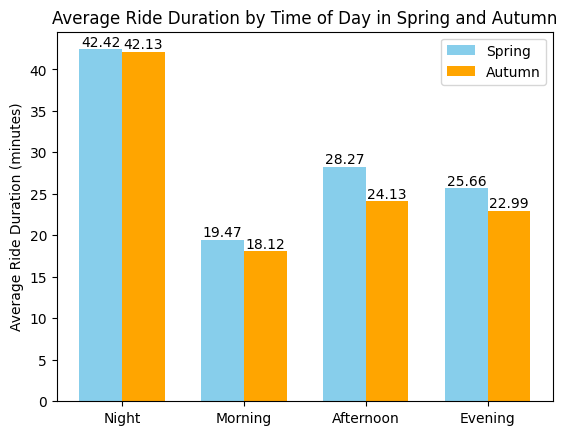

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def filter_by_time_of_day(data, start_hour, end_hour):
    return data.filter((data['hour_of_day'] >= start_hour) & (data['hour_of_day'] <= end_hour))

time_ranges = [
    (0, 5, 'Night'),
    (6, 11, 'Morning'),
    (12, 17, 'Afternoon'),
    (18, 23, 'Evening')
]

#Initialize lists to store average ride durations for spring and autumn
spring_avg_durations = []
autumn_avg_durations = []

for start_hour, end_hour, time_label in time_ranges:
    spring_time_data = filter_by_time_of_day(spring_clean, start_hour, end_hour)
    autumn_time_data = filter_by_time_of_day(autumn_clean, start_hour, end_hour)
    
    average_spring_time_duration = spring_time_data.agg({'Duration_minutes': 'mean'}).collect()[0][0]
    average_autumn_time_duration = autumn_time_data.agg({'Duration_minutes': 'mean'}).collect()[0][0]

    spring_avg_durations.append(average_spring_time_duration)
    autumn_avg_durations.append(average_autumn_time_duration)

    print(f"Average {time_label} ride duration in spring:", average_spring_time_duration)
    print(f"Average {time_label} ride duration in autumn:", average_autumn_time_duration)
    print("\n")


#Set the bar width
bar_width = 0.35

#Set the x-axis positions for the spring and autumn bars
spring_bar_positions = np.arange(len(time_ranges))
autumn_bar_positions = [x + bar_width for x in spring_bar_positions]

#Create the bar plot
spring_bars = plt.bar(spring_bar_positions, spring_avg_durations, width=bar_width, label='Spring', color='skyblue')
autumn_bars = plt.bar(autumn_bar_positions, autumn_avg_durations, width=bar_width, label='Autumn', color='orange')

#Add the values as text above the bars
for bars in (spring_bars, autumn_bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.2f}'.format(height), ha='center', va='bottom', fontsize=10)

#Add x-axis labels
time_labels = [time_label for _, _, time_label in time_ranges]
plt.xticks([r + bar_width / 2 for r in spring_bar_positions], time_labels)

#Set the y-axis label and the plot title
plt.ylabel('Average Ride Duration (minutes)')
plt.title('Average Ride Duration by Time of Day in Spring and Autumn')

#Add a legend
plt.legend()

#Display the plot
plt.show()